In [1]:
# Import the required libraries and open the connection to Mongo

import collections
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import random

import numpy as np
import pandas as pd
import scipy.stats

import pymongo
from bson.objectid import ObjectId

In [2]:
client = pymongo.MongoClient('mongodb://localhost:27017')

In [3]:
# Connect to the database
summerofcode_db = client.summerofcode
imp = summerofcode_db.imp
icmas = summerofcode_db.icmas

In [4]:
icmas.find_one();

# Attempts per task

In [5]:
pipeline = [{"$group": {"_id": "$icma_number", "count": {"$sum": 1}}},
            {'$sort': {'_id': 1}}]
list(icmas.aggregate(pipeline))

[{'_id': 0, 'count': 292},
 {'_id': 1, 'count': 152},
 {'_id': 2, 'count': 102},
 {'_id': 3, 'count': 87},
 {'_id': 4, 'count': 96},
 {'_id': 5, 'count': 76},
 {'_id': 6, 'count': 99},
 {'_id': 7, 'count': 53},
 {'_id': 8, 'count': 60},
 {'_id': 9, 'count': 41},
 {'_id': 10, 'count': 60}]

# Submissions per person per task

Includes non-submitted attempts.

In [6]:
pipeline = [{"$group": {"_id": {'icma_number': "$icma_number",
                                'pi': '$Personal Identifier'},
                        "scores": {"$push": '$grade'}}}]
list(icmas.aggregate(pipeline));

In [7]:
pipeline = [{"$group": {"_id": {'icma_number': "$icma_number",
                                'pi': '$Personal Identifier'},
                        "scores": {"$push": '$grade'}}},
            {'$project': {'scores': True,
                          'n_attempts': {'$size': '$scores'},
                          'highest': {'$max': '$scores'}}}]
attempts_per_person = pd.DataFrame([
    {'icma_number': r['_id']['icma_number'],
     'pi': r['_id']['pi'],
     'n_attempts': r['n_attempts']}
    for r in icmas.aggregate(pipeline)
])
attempts_per_person;

In [8]:
attempts_per_person.groupby(['n_attempts']).count()

,icma_number,pi
n_attempts,,
1,776,776
2,91,91
3,20,20
4,10,10
5,4,4
6,3,3
7,2,2
8,1,1


In [9]:
attempts_per_person[attempts_per_person.icma_number > 0].groupby(['n_attempts']).count()

,icma_number,pi
n_attempts,,
1,522,522
2,77,77
3,18,18
4,9,9
5,4,4
6,3,3
7,2,2
8,1,1


## Number of submissions per person

In [10]:
pipeline = [{'$match': {'grade': {'$ne': '-'},
                        'icma_number': {'$gt': 0}}},
            {"$group": {"_id": {'icma_number': "$icma_number",
                                'pi': '$Personal Identifier'},
                        "scores": {"$push": '$grade'}}},
            {'$project': {'scores': True,
                          'n_attempts': {'$size': '$scores'},
                          'highest': {'$max': '$scores'}}}]
submissions_per_person = pd.DataFrame([
    {'icma_number': r['_id']['icma_number'],
     'pi': r['_id']['pi'],
     'n_attempts': r['n_attempts']}
    for r in icmas.aggregate(pipeline)
])
submissions_per_person;

In [11]:
submissions_per_person.groupby(['n_attempts']).count()

,icma_number,pi
n_attempts,,
1,349,349
2,53,53
3,16,16
4,8,8
5,4,4
6,2,2
7,2,2
8,1,1


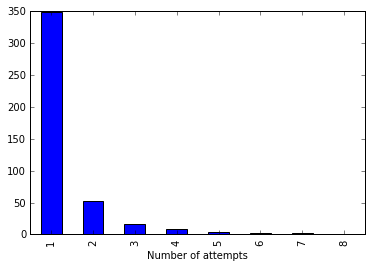

In [12]:
ax = submissions_per_person.groupby(['n_attempts'])['icma_number'].count().plot(kind='bar')
ax.set_xlabel('Number of attempts')
plt.savefig('attempts-per-day.png')

In [13]:
submissions_per_person.groupby(['icma_number', 'n_attempts']).count().unstack().fillna(value=0).astype(int)

pi                      
n_attempts    1   2  3  4  5  6  7  8
icma_number                          
1            59  13  3  0  0  0  0  0
2            61   5  2  1  0  0  0  0
3            56   2  1  0  0  0  0  0
4            31  10  4  0  1  0  0  0
5            34   4  1  1  0  0  1  0
6            18   8  2  2  2  2  1  0
7            30   1  0  0  1  0  0  0
8            16   3  1  3  0  0  0  0
9            28   1  0  0  0  0  0  0
10           16   6  2  1  0  0  0  1

In [14]:
submissions_per_person.groupby(['icma_number', 'n_attempts']).count().unstack().fillna(value=0).astype(int).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr>\n      <th></th>\n      <th colspan="8" halign="left">pi</th>\n    </tr>\n    <tr>\n      <th>n_attempts</th>\n      <th>1</th>\n      <th>2</th>\n      <th>3</th>\n      <th>4</th>\n      <th>5</th>\n      <th>6</th>\n      <th>7</th>\n      <th>8</th>\n    </tr>\n    <tr>\n      <th>icma_number</th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>1</th>\n      <td>59</td>\n      <td>13</td>\n      <td>3</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>61</td>\n      <td>5</td>\n      <td>2</td>\n      <td>1</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>56</td>\n      <td>2</td>\n      <td>1</td>\n      <td>0</td

# Grade per person per task, keeping only best score

In [15]:
pipeline = [{"$group": {"_id": {'icma_number': "$icma_number",
                                'pi': '$Personal Identifier'},
                        "scores": {"$push": '$grade'}}},
            {'$project': {'scores': True,
                          'n_attempts': {'$size': '$scores'},
                          'highest': {'$max': '$scores'}}},
            {'$group': {'_id': {'icma_number': '$_id.icma_number',
                                'grade': '$highest'},
                        "count": {"$sum": 1}}}]
icma_score_long = pd.DataFrame([
    {'icma_number': r['_id']['icma_number'],
     'grade': r['_id']['grade'],
     'num': r['count']}
    for r in icmas.aggregate(pipeline)
])
icma_score_long

,grade,icma_number,num
0,5,6,1
1,0,6,1
2,-,5,20
3,10,6,28
4,-,6,22
5,-,8,23
6,0,0,2
7,5,1,1
8,5,4,2
9,5,0,3


In [16]:
# Old version, counting each attempt separately
#
# pipeline = [{"$group": {"_id": {'icma_number': "$icma_number",
#                                 'grade': '$grade'},
#                         "count": {"$sum": 1}}}]
# icma_score_long = pd.DataFrame([
#     {'icma_number': r['_id']['icma_number'],
#      'grade': r['_id']['grade'],
#      'num': r['count']}
#     for r in icmas.aggregate(pipeline)
# ])
# icma_score_long

In [17]:
icma_score = icma_score_long.pivot(index='icma_number', columns='grade', values='num').fillna(value=0).astype(int)
icma_score

grade,0.0,5.0,10.0,-
icma_number,,,,
0,2,3,87,179
1,1,1,68,58
2,0,2,63,21
3,0,0,53,24
4,0,2,40,28
5,0,0,40,20
6,1,1,28,22
7,0,0,30,16
8,0,0,20,23


In [18]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))
    return df_formatted.to_csv(sep="|", index=False)

In [19]:
print(pandas_df_to_markdown_table(icma_score))

0.0|5.0|10.0|-
---|---|---|---
2|3|87|179
1|1|68|58
0|2|63|21
0|0|53|24
0|2|40|28
0|0|40|20
1|1|28|22
0|0|30|16
0|0|20|23
0|0|26|11
0|0|23|14


0.0|5.0|10.0|-
---|---|---|---
2|3|87|179
1|1|68|58
0|2|63|21
0|0|53|24
0|2|40|28
0|0|40|20
1|1|28|22
0|0|30|16
0|0|20|23
0|0|26|11
0|0|23|14



In [20]:
icma_score.loc[1:]

grade,0.0,5.0,10.0,-
icma_number,,,,
1,1,1,68,58
2,0,2,63,21
3,0,0,53,24
4,0,2,40,28
5,0,0,40,20
6,1,1,28,22
7,0,0,30,16
8,0,0,20,23
9,0,0,26,11


In [21]:
icma_score.loc[1:].to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>grade</th>\n      <th>0.0</th>\n      <th>5.0</th>\n      <th>10.0</th>\n      <th>-</th>\n    </tr>\n    <tr>\n      <th>icma_number</th>\n      <th></th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>1</th>\n      <td>1</td>\n      <td>1</td>\n      <td>68</td>\n      <td>58</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>0</td>\n      <td>2</td>\n      <td>63</td>\n      <td>21</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>0</td>\n      <td>0</td>\n      <td>53</td>\n      <td>24</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>0</td>\n      <td>2</td>\n      <td>40</td>\n      <td>28</td>\n    </tr>\n    <tr>\n      <th>5</th>\n      <td>0</td>\n      <td>0</td>\n      <td>40</td>\n      <td>20</td>\n    </tr>\n    <tr>\n      <th>6</th>\n      <td>1</td>\n      <td>1</td>\n      <td>28</td>\n      <td>22<

In [22]:
icma_score.loc[1:, icma_score.columns != '-']

grade,0.0,5.0,10.0
icma_number,,,
1,1,1,68
2,0,2,63
3,0,0,53
4,0,2,40
5,0,0,40
6,1,1,28
7,0,0,30
8,0,0,20
9,0,0,26


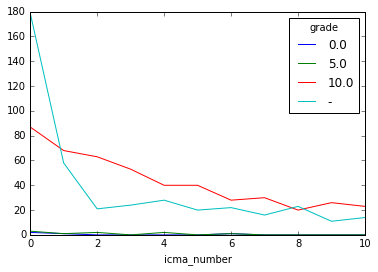

In [23]:
icma_score.plot()

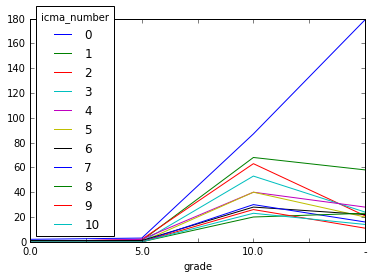

In [24]:
icma_score.T.plot()

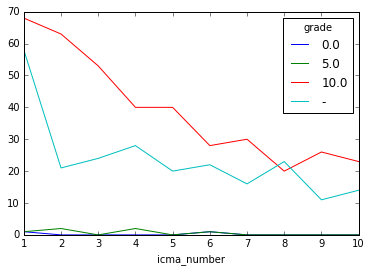

In [25]:
icma_score.loc[1:].plot()

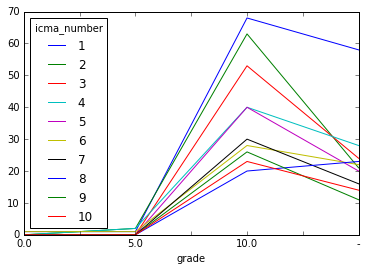

In [26]:
icma_score.loc[1:].T.plot()

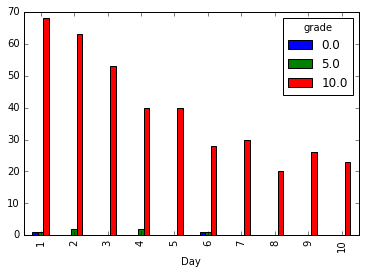

In [27]:
ax = icma_score.loc[1:, icma_score.columns != '-'].plot(kind='bar', xticks=list(range(1, 11)))
ax.set_xlabel('Day')

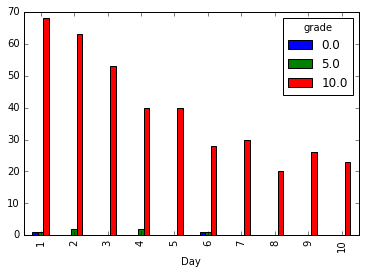

In [28]:
ax = icma_score.loc[1:, icma_score.columns != '-'].plot(kind='bar', xticks=list(range(1, 11)))
ax.set_xlabel('Day')
plt.savefig('scores-per-day.png')

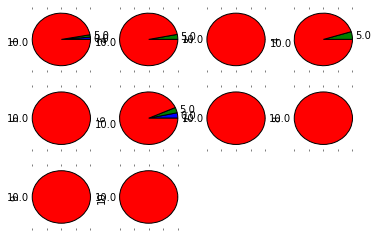

In [29]:
# plt.tight_layout()
ax = icma_score.loc[1:, icma_score.columns != '-'].T.plot(kind='pie', subplots=True, legend=False, layout=(3, 4))
# plt.tight_layout()

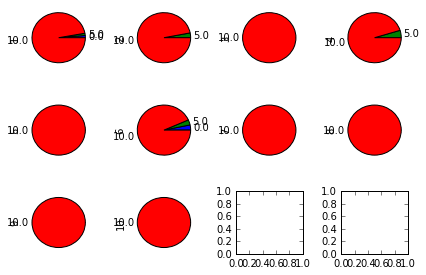

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=4)
fig.tight_layout()

target_ax = [axes[r][c] for r in range(3) for c in range(4) if not (r == 2 and c >= 2)]

ax = icma_score.loc[1:, icma_score.columns != '-'].T.plot(kind='pie', subplots=True, legend=False, 
                                                          ax=target_ax, sharex=False, sharey=False)

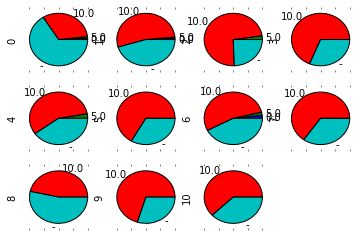

In [31]:
ax = icma_score.T.plot(kind='pie', subplots=True, legend=False, layout=(3, 4))

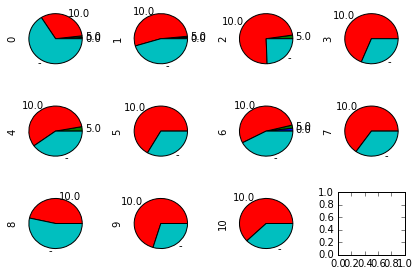

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4)
fig.tight_layout()

target_ax = [axes[r][c] for r in range(3) for c in range(4) if not (r == 2 and c >= 3)]

ax = icma_score.T.plot(kind='pie', subplots=True, legend=False, 
                                                          ax=target_ax, sharex=False, sharey=False)

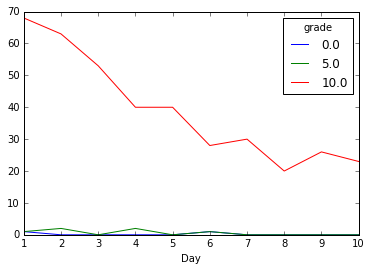

In [33]:
ax = icma_score.loc[1:, icma_score.columns != '-'].plot(xticks=list(range(1, 11)))
ax.set_xlabel('Day')

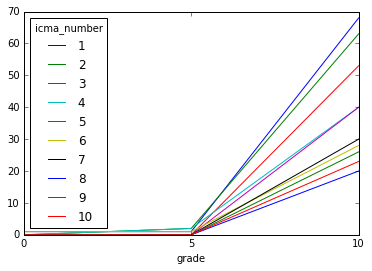

In [34]:
icma_score.loc[1:, icma_score.columns != '-'].T.plot(xticks=[0, 5, 10])

# People participating in each task

In [35]:
pipeline = [{"$group": {"_id": "$icma_number",
                        "participants": {"$addToSet": '$Personal Identifier'}}},
            {"$project": {"participants": True,
                         'num_participants': {"$size": "$participants"}}}]
list(icmas.aggregate(pipeline));

In [36]:
pipeline = [{"$group": {"_id": "$icma_number",
                        "participants": {"$addToSet": '$Personal Identifier'}}},
            {"$project": {'num_participants': {"$size": "$participants"}}}]

participants_per_day = pd.Series(
    {r['_id']: r['num_participants']
        for r in icmas.aggregate(pipeline)
    })
participants_per_day
#     sorted(list(icmas.aggregate(pipeline)), key=lambda r: r['_id'])

0     271
1     128
2      86
3      77
4      70
5      60
6      52
7      46
8      43
9      37
10     37
dtype: int64

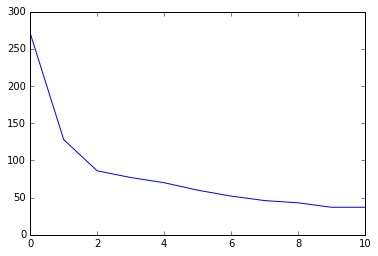

In [37]:
participants_per_day.plot()

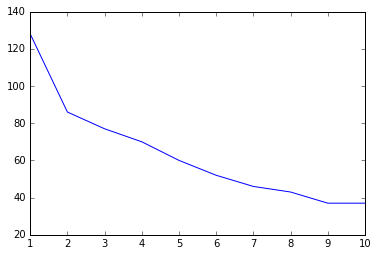

In [38]:
participants_per_day[1:].plot()

## Actual submissions, not unfinished attempts

In [39]:
pipeline = [{'$match': {'grade': {'$ne': '-'}}},
            {"$group": {"_id": "$icma_number",
                        "participants": {"$addToSet": '$Personal Identifier'}}},
            {"$project": {'participants': True,
                          'num_participants': {"$size": "$participants"}}}]
list(icmas.aggregate(pipeline));

## Those getting full marks on each day

In [40]:
pipeline = [{'$match': {'grade': 10}},
            {"$group": {"_id": "$icma_number",
                        "participants": {"$addToSet": '$Personal Identifier'}}},
            {"$project": {'participants': True,
                          'num_participants': {"$size": "$participants"}}}]
completers = {r['_id']: r for r in icmas.aggregate(pipeline)}
completers;

In [41]:
completers[5];

In [42]:
prize_candidates = {}
for i in icmas.find({}).distinct('icma_number'):
    earliest = icmas.find_one({'icma_number': i}, sort=[("started", 1)])["started"]
    icma_finish = earliest.replace(day=earliest.day+1, hour=0, minute=0, second=0)
    prize_candidates[i] = list(
        icmas.find({'icma_number': i,
            'grade': 10,
            'completed': {'$lt': icma_finish}},
               ['Personal Identifier', 'Email address', 'First name', 'Surname', 'completed']))
prize_candidates;

In [43]:
# for i in prize_candidates:
#     winner = random.choice(prize_candidates[i])
#     print('Day {}: {} {} PI {} email {}'.format(
#         i,
#         winner['First name'],
#         winner['Surname'],
#         winner['Personal Identifier'],
#         winner['Email address']
#         ))

# Times of starting and finishing

In [44]:
# all_starts = pd.DataFrame([{'icma_number': r['icma_number'], 'start_time': r['started'].time()}
#               for r in icmas.find({}, ['icma_number', 'started'])])
# all_starts[:10]

In [45]:
all_starts = pd.DataFrame([{'icma_number': r['icma_number'], 'start_time': r['started'].hour}
              for r in icmas.find({}, ['icma_number', 'started'])])
all_starts[:10]

,icma_number,start_time
0,9,10
1,9,11
2,9,12
3,9,11
4,9,12
5,9,12
6,9,12
7,9,12
8,9,14
9,9,16


In [46]:
all_starts_x = pd.crosstab(all_starts.start_time, all_starts.icma_number)
all_starts_x.sum(axis=1)

start_time
0     98
1     22
2     20
3      7
4      5
5      5
6     31
7     40
8     60
9     67
10    61
11    72
12    58
13    59
14    49
15    61
16    56
17    50
18    53
19    45
20    55
21    51
22    43
23    50
dtype: int64

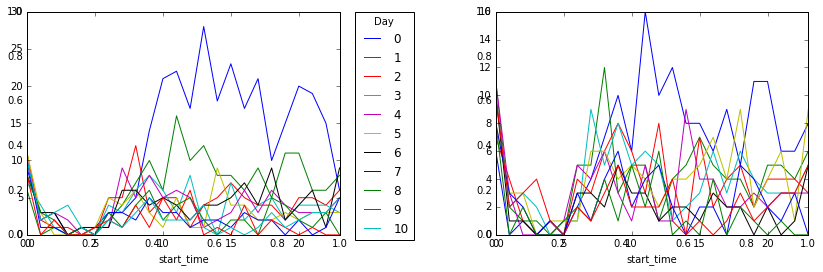

In [47]:
fig = plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(14, 4));
plt.subplots_adjust(wspace=0.5, hspace=0.5);

ax = fig.add_subplot(1,2,2)
all_starts_x.ix[:, all_starts_x.columns != 0].plot(ax=ax, legend=False, sharex=False, sharey=False)

ax = fig.add_subplot(1,2,1)
all_starts_x.plot(ax=ax, legend=False, sharex=False, sharey=False)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Day")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0e3d43518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc10f0ac278>]], dtype=object)

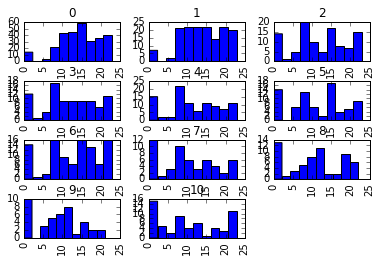

In [48]:
all_starts.start_time.hist(by=all_starts.icma_number)

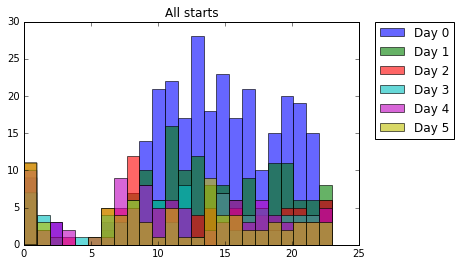

In [49]:
for i in range(6):
    plt.hist(all_starts[all_starts.icma_number==i]['start_time'].reset_index(drop=True), 
             bins=24,
             alpha=0.6, 
             label="Day {}".format(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("All starts")
plt.show()

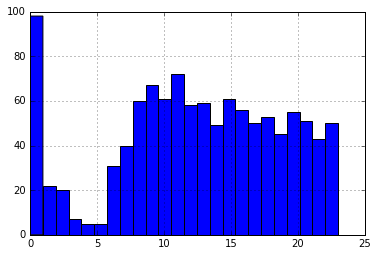

In [50]:
all_starts.start_time.hist(bins=24)

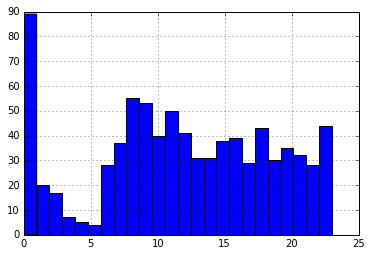

In [51]:
all_starts[all_starts.icma_number > 0].start_time.hist(bins=24)
plt.savefig('all-starts-hours.png')

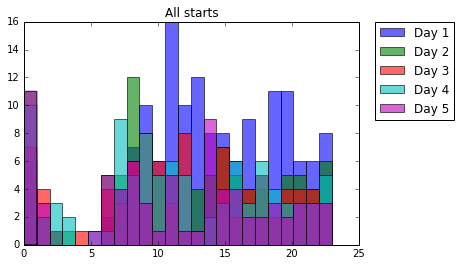

In [52]:
for i in range(1, 6):
    plt.hist(all_starts[all_starts.icma_number==i]['start_time'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("All starts")
plt.show()

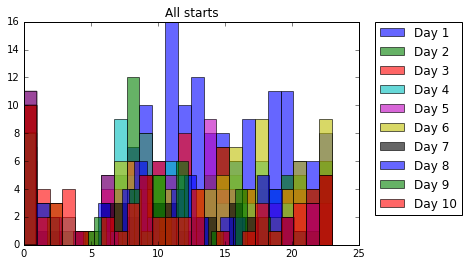

In [53]:
for i in range(1, 11):
    plt.hist(all_starts[all_starts.icma_number==i]['start_time'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("All starts")
plt.show()

In [54]:
completed_starts = pd.DataFrame([{'icma_number': r['icma_number'], 'start_time': r['started'].hour}
              for r in icmas.find({'completed': {'$exists': True}}, ['icma_number', 'started'])])
completed_starts[:10]

,icma_number,start_time
0,9,10
1,9,11
2,9,12
3,9,11
4,9,12
5,9,12
6,9,12
7,9,12
8,9,14
9,9,16


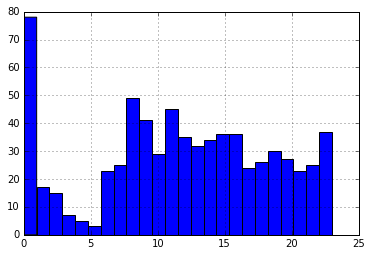

In [55]:
completed_starts.start_time.hist(bins=24)

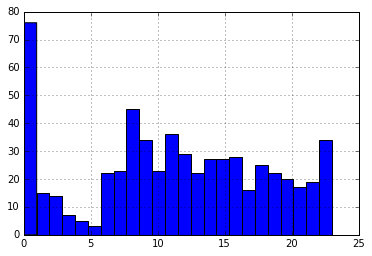

In [56]:
completed_starts[completed_starts.icma_number > 0].start_time.hist(bins=24)

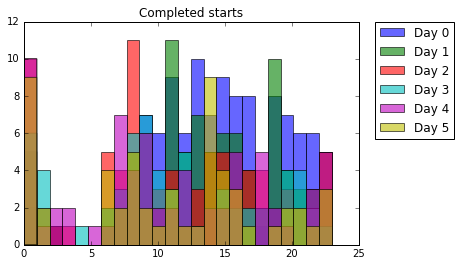

In [57]:
for i in range(6):
    plt.hist(completed_starts[completed_starts.icma_number==i]['start_time'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Completed starts")
plt.show()

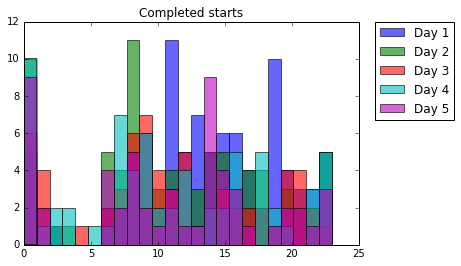

In [58]:
for i in range(1, 6):
    plt.hist(completed_starts[completed_starts.icma_number==i]['start_time'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Completed starts")
plt.show()

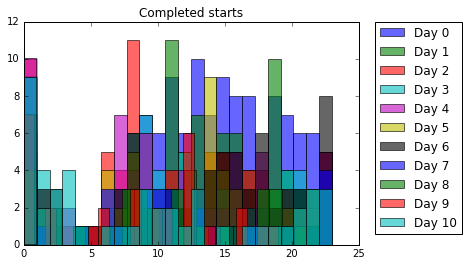

In [59]:
for i in range(11):
    plt.hist(completed_starts[completed_starts.icma_number==i]['start_time'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Completed starts")
plt.show()

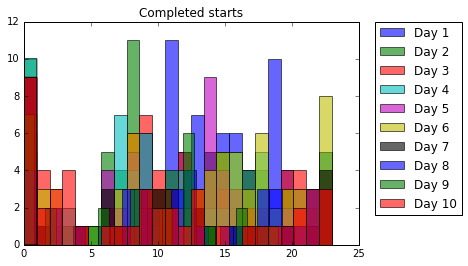

In [60]:
for i in range(1, 11):
    plt.hist(completed_starts[completed_starts.icma_number==i]['start_time'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Completed starts")
plt.show()

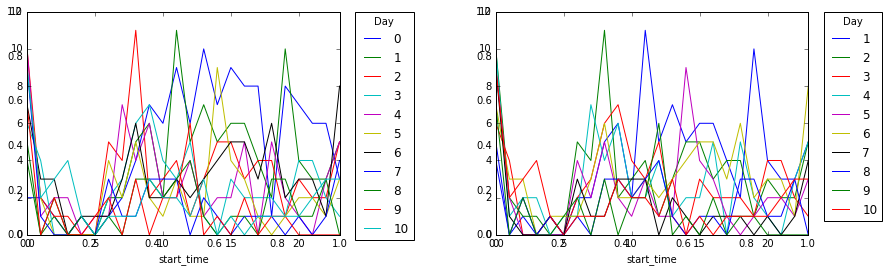

In [61]:
completed_starts_x = pd.crosstab(completed_starts.start_time, completed_starts.icma_number)

fig = plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(14, 4));
plt.subplots_adjust(wspace=0.5, hspace=0.5);

ax = fig.add_subplot(1,2,2)
completed_starts_x.ix[:, completed_starts_x.columns != 0].plot(ax=ax, legend=False, sharex=False, sharey=False)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Day")

ax = fig.add_subplot(1,2,1)
completed_starts_x.plot(ax=ax, legend=False, sharex=False, sharey=False)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Day")

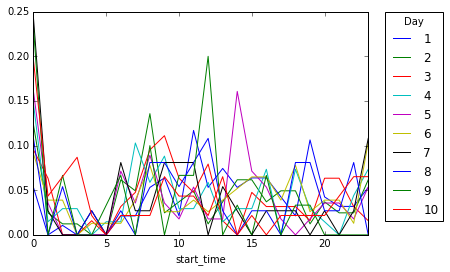

In [62]:
completed_starts_x_normalised = completed_starts_x / completed_starts_x.sum()
ax = completed_starts_x_normalised.ix[:, completed_starts_x_normalised.columns != 0].plot(legend=False)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Day")

In [63]:
completions = pd.DataFrame([{'icma_number': r['icma_number'], 'completed': r['completed'].hour}
              for r in icmas.find({'completed': {'$exists': True}}, ['icma_number', 'completed'])])
completions[:10]

,completed,icma_number
0,15,9
1,13,9
2,17,9
3,9,9
4,21,9
5,12,9
6,14,9
7,15,9
8,15,9
9,15,9


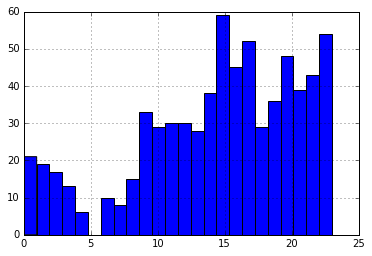

In [64]:
completions.completed.hist(bins=24)

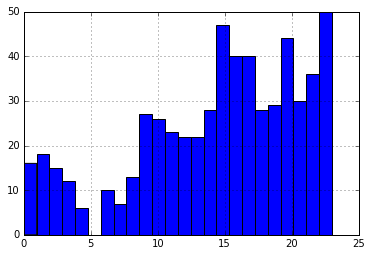

In [65]:
completions[completions.icma_number > 0].completed.hist(bins=24)
plt.savefig('completion-hours.png')

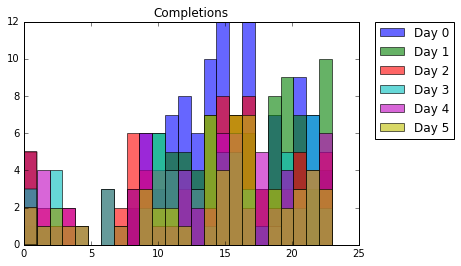

In [66]:
for i in range(6):
    plt.hist(completions[completions.icma_number==i]['completed'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Completions")
plt.show()

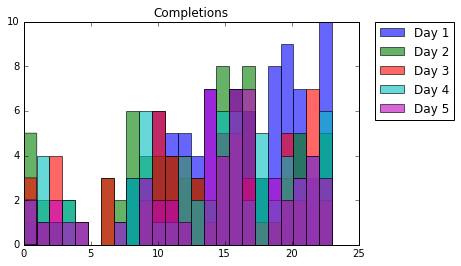

In [67]:
for i in range(1, 6):
    plt.hist(completions[completions.icma_number==i]['completed'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Completions")
plt.show()

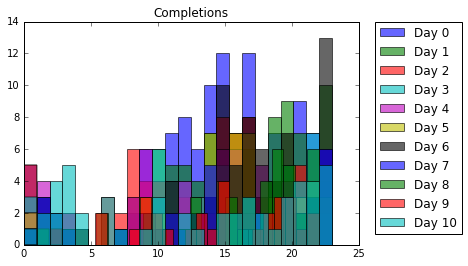

In [68]:
for i in range(11):
    plt.hist(completions[completions.icma_number==i]['completed'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Completions")
plt.show()

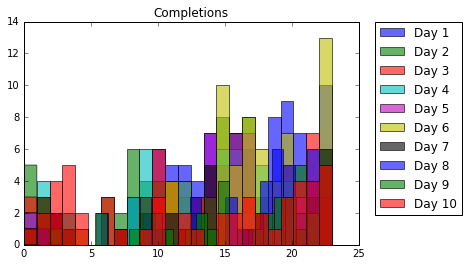

In [69]:
for i in range(1, 11):
    plt.hist(completions[completions.icma_number==i]['completed'].reset_index(drop=True), 
             alpha=0.6, label="Day {}".format(i), bins=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Completions")
plt.show()

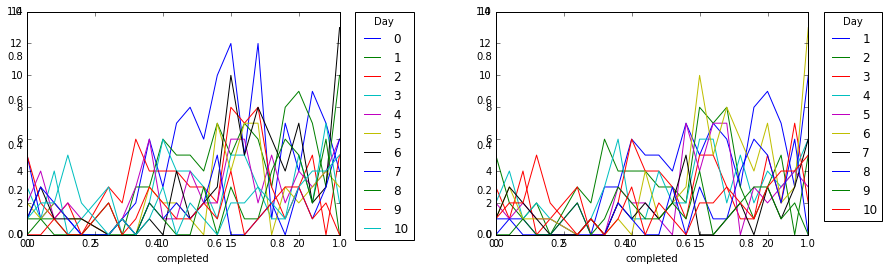

In [70]:
completions_x = pd.crosstab(completions.completed, completions.icma_number)

fig = plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(14, 4));
plt.subplots_adjust(wspace=0.5, hspace=0.5);

ax = fig.add_subplot(1,2,2)
completions_x.ix[:, completions_x.columns != 0].plot(ax=ax, legend=False, sharex=False, sharey=False)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Day")

ax = fig.add_subplot(1,2,1)
completions_x.plot(ax=ax, legend=False, sharex=False, sharey=False)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Day")

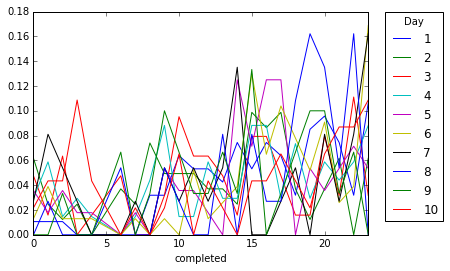

In [71]:
completions_x_normalised = completions_x / completions_x.sum()
ax = completions_x_normalised.ix[:, completions_x_normalised.columns != 0].plot(legend=False)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Day")

# Delayed days of starting and finishing

In [72]:
start_days = {}
for i in icmas.find({}).distinct('icma_number'):
    earliest = icmas.find_one({'icma_number': i}, sort=[("started", 1)])["started"]
    start_days[i] = earliest.replace(day=earliest.day, hour=0, minute=0, second=0)
start_days

{0: datetime.datetime(2017, 6, 2, 0, 0),
 1: datetime.datetime(2017, 7, 17, 0, 0),
 2: datetime.datetime(2017, 7, 18, 0, 0),
 3: datetime.datetime(2017, 7, 19, 0, 0),
 4: datetime.datetime(2017, 7, 20, 0, 0),
 5: datetime.datetime(2017, 7, 21, 0, 0),
 6: datetime.datetime(2017, 7, 24, 0, 0),
 7: datetime.datetime(2017, 7, 25, 0, 0),
 8: datetime.datetime(2017, 7, 26, 0, 0),
 9: datetime.datetime(2017, 7, 27, 0, 0),
 10: datetime.datetime(2017, 7, 28, 0, 0)}

In [73]:
start_delays_dict = {}
for i in icmas.find({}).distinct('icma_number'):
    attempts = [(a['started'] - start_days[i]).days for a in icmas.find({'icma_number': i}, ['started'])]
    start_delays_dict[i] = collections.Counter(attempts)
start_delays_dict

{0: Counter({0: 13,
          1: 3,
          2: 5,
          3: 5,
          4: 9,
          5: 8,
          6: 23,
          7: 20,
          8: 10,
          9: 4,
          10: 10,
          11: 12,
          12: 6,
          13: 6,
          14: 3,
          15: 3,
          16: 3,
          17: 10,
          18: 5,
          19: 2,
          20: 7,
          21: 2,
          22: 4,
          23: 2,
          24: 3,
          25: 5,
          26: 5,
          27: 3,
          28: 2,
          29: 2,
          30: 1,
          31: 1,
          32: 5,
          33: 3,
          34: 2,
          35: 3,
          37: 2,
          38: 5,
          39: 2,
          40: 2,
          41: 13,
          42: 9,
          43: 4,
          44: 2,
          45: 18,
          46: 6,
          47: 4,
          48: 4,
          49: 2,
          50: 4,
          51: 1,
          52: 1,
          53: 2,
          59: 1}),
 1: Counter({0: 86,
          1: 19,
          2: 13,
          3: 9,
        

In [74]:
start_delays = pd.DataFrame(start_delays_dict).T.fillna(0)
start_delays

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,59
0,13.0,3.0,5.0,5.0,9.0,8.0,23.0,20.0,10.0,4.0,...,18.0,6.0,4.0,4.0,2.0,4.0,1.0,1.0,2.0,1.0
1,86.0,19.0,13.0,9.0,7.0,5.0,2.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,11.0,11.0,7.0,2.0,1.0,3.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58.0,12.0,5.0,5.0,0.0,1.0,3.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.0,5.0,2.0,5.0,8.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,56.0,4.0,3.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,79.0,9.0,2.0,2.0,2.0,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,47.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,48.0,2.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,34.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
start_delays.iloc[1:, :12]

,0,1,2,3,4,5,6,7,8,9,10,11
1,86.0,19.0,13.0,9.0,7.0,5.0,2.0,5.0,1.0,3.0,1.0,0.0
2,62.0,11.0,11.0,7.0,2.0,1.0,3.0,2.0,2.0,0.0,0.0,0.0
3,58.0,12.0,5.0,5.0,0.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0
4,73.0,5.0,2.0,5.0,8.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
5,56.0,4.0,3.0,4.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0
6,79.0,9.0,2.0,2.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0
7,47.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
8,48.0,2.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,34.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,52.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


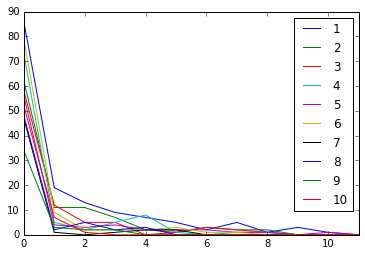

In [76]:
start_delays.iloc[1:, :12].T.plot()

In [77]:
completion_delays_dict = {}
for i in icmas.find({}).distinct('icma_number'):
    attempts = [(a['completed'] - start_days[i]).days for a in icmas.find(
        {'icma_number': i, 'completed': {'$exists': True}}, ['completed'])]
    completion_delays_dict[i] = collections.Counter(attempts)
completion_delays_dict

{0: Counter({0: 1,
          1: 1,
          2: 3,
          3: 1,
          4: 1,
          5: 1,
          6: 9,
          7: 10,
          8: 8,
          9: 4,
          10: 6,
          11: 3,
          12: 4,
          13: 2,
          14: 2,
          15: 1,
          17: 6,
          20: 4,
          22: 1,
          24: 2,
          26: 2,
          28: 1,
          32: 2,
          38: 1,
          39: 1,
          40: 1,
          41: 5,
          42: 3,
          43: 2,
          44: 2,
          45: 10,
          46: 1,
          47: 1,
          48: 2,
          49: 2,
          50: 4,
          51: 1,
          52: 2}),
 1: Counter({0: 60, 1: 12, 2: 5, 3: 4, 4: 7, 5: 2, 7: 2, 8: 1, 14: 1}),
 2: Counter({0: 49, 1: 12, 2: 9, 3: 5, 4: 1, 5: 1, 6: 2, 7: 2}),
 3: Counter({0: 44, 1: 4, 2: 4, 3: 2, 4: 2, 5: 1, 6: 3, 7: 1, 10: 1, 12: 1}),
 4: Counter({0: 48, 1: 6, 2: 1, 3: 4, 4: 3, 5: 2, 6: 1, 7: 2, 11: 1}),
 5: Counter({0: 36, 1: 2, 2: 1, 3: 3, 4: 5, 5: 2, 6: 3, 8: 2, 10: 2}),


In [78]:
completion_delays = pd.DataFrame(completion_delays_dict).T.fillna(0).astype(int)
completion_delays

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,1,1,3,1,1,1,9,10,8,4,...,2,2,10,1,1,2,2,4,1,2
1,60,12,5,4,7,2,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
2,49,12,9,5,1,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44,4,4,2,2,1,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,48,6,1,4,3,2,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,36,2,1,3,5,2,3,0,2,0,...,0,0,0,0,0,0,0,0,0,0
6,59,9,2,0,0,3,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
7,31,4,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,26,1,6,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,23,4,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
longest_completion_delay = max(c for c in completion_delays.columns if completion_delays[c][1:].sum() >= 1)
longest_completion_delay

14

In [80]:
completion_delays.iloc[1:, :longest_completion_delay+1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,60,12,5,4,7,2,0,2,1,0,0,0,0,0,1
2,49,12,9,5,1,1,2,2,0,0,0,0,0,0,0
3,44,4,4,2,2,1,3,1,0,0,1,0,1,0,0
4,48,6,1,4,3,2,1,2,0,0,0,1,0,0,0
5,36,2,1,3,5,2,3,0,2,0,2,0,0,0,0
6,59,9,2,0,0,3,2,2,0,0,0,0,0,0,0
7,31,4,0,0,1,0,1,0,0,0,0,0,0,0,0
8,26,1,6,1,2,1,0,0,0,0,0,0,0,0,0
9,23,4,1,1,1,0,0,0,0,0,0,0,0,0,0
10,35,9,2,0,0,0,0,0,0,0,0,0,0,0,0


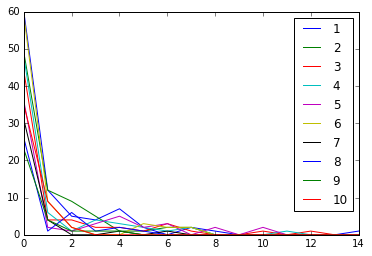

In [81]:
completion_delays.iloc[1:, :longest_completion_delay+1].T.plot()

# People attempting per day

In [82]:
pipeline = [{'$match': {'grade': {'$ne': '-'}}},
            {'$project': {'grade': True}}]
set(r['grade'] for r in icmas.aggregate(pipeline))

{0.0, 5.0, 10.0}

In [83]:
pipeline = [{"$group": {"_id": {'icma_number': "$icma_number",
                                'grade': '$grade'},
                        "participants": {"$addToSet": '$Personal Identifier'}}}]
participant_grades = {(r['_id']['icma_number'], r['_id']['grade']): r['participants'] 
                      for r in icmas.aggregate(pipeline)}
participant_grades;

In [84]:
sorted(participant_grades.keys(), key=lambda k: k[0])

[(0, 10.0),
 (0, 0.0),
 (0, 5.0),
 (0, '-'),
 (1, 5.0),
 (1, 10.0),
 (1, '-'),
 (1, 0.0),
 (2, 5.0),
 (2, '-'),
 (2, 10.0),
 (2, 0.0),
 (3, 0.0),
 (3, 10.0),
 (3, 5.0),
 (3, '-'),
 (4, 0.0),
 (4, '-'),
 (4, 10.0),
 (4, 5.0),
 (5, '-'),
 (5, 5.0),
 (5, 0.0),
 (5, 10.0),
 (6, '-'),
 (6, 10.0),
 (6, 0.0),
 (6, 5.0),
 (7, 10.0),
 (7, 0.0),
 (7, '-'),
 (7, 5.0),
 (8, 0.0),
 (8, '-'),
 (8, 5.0),
 (8, 10.0),
 (9, 0.0),
 (9, 10.0),
 (9, '-'),
 (9, 5.0),
 (10, 0.0),
 (10, '-'),
 (10, 5.0),
 (10, 10.0)]

In [85]:
icma_numbers = sorted(set(k[0] for k in participant_grades))
best_grades_participants = {}
for icma in icma_numbers:
    prps = set()
    for grade in [10, 5, 0, '-']:
        pis = set(participant_grades.get((icma, grade), []))
        best_grades_participants[icma, grade] = pis - prps
        prps |= pis
best_grades_participants;

In [86]:
pbgs = [{'pi': pi, 'icma': icma, 'grade': grade} 
        for ((icma, grade), pis) in best_grades_participants.items() 
        for pi in pis]
ps = set(p['pi'] for p in pbgs)
participant_best_grades = {pi: {p['icma']: p['grade'] 
                                for p in pbgs
                                if p['pi'] == pi}
                           for pi in ps}
participant_best_grades;

In [87]:
pbgs[:10];

In [88]:
def count_tasks(scores, exclude_intro=True):
    if exclude_intro:
        return sum(1 for i in scores if i > 0)
    else:
        return len(scores)

In [89]:
def consecutive_tasks(scores, exclude_intro=True):
    count = 0
    if exclude_intro:
        task = 1
    else:
        task = 0
    while task in scores:
        count += 1
        task += 1
    return count        

In [90]:
# for pi in participant_best_grades:
#     grades = participant_best_grades[pi]
#     print('{}, {} tasks, {} consecutive: {}'.format(pi, 
#                                                     count_tasks(grades),
#                                                     consecutive_tasks(grades),
#                                                     grades))

In [91]:
participation = {pi: 
                 {'tasks': count_tasks(participant_best_grades[pi]),
                  'consecutive': consecutive_tasks(participant_best_grades[pi])}
    for pi in participant_best_grades
    if count_tasks(participant_best_grades[pi]) > 0
}
participation;

In [92]:
participation_intro = {pi: 
                 {'tasks': count_tasks(participant_best_grades[pi], exclude_intro=False),
                  'consecutive': consecutive_tasks(participant_best_grades[pi], exclude_intro=False)}
    for pi in participant_best_grades
    if count_tasks(participant_best_grades[pi]) > 0
}
participation_intro;

In [93]:
collections.Counter(participation[pi]['tasks'] for pi in participation)

Counter({1: 51, 2: 12, 3: 11, 4: 4, 5: 8, 6: 5, 7: 5, 8: 4, 9: 5, 10: 33})

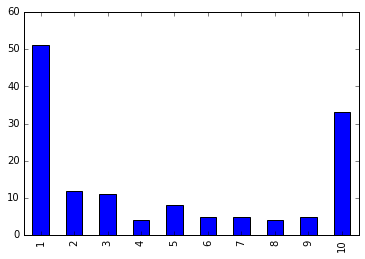

In [94]:
pd.Series(collections.Counter(participation[pi]['tasks'] 
                              for pi in participation)).plot(kind='bar');
collections.Counter(participation[pi]['tasks'] 
                    for pi in participation)
plt.savefig('participated-in-days.png')

In [95]:
pd.Series(collections.Counter(participation[pi]['tasks'] 
                    for pi in participation)).to_frame().T.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>1</th>\n      <th>2</th>\n      <th>3</th>\n      <th>4</th>\n      <th>5</th>\n      <th>6</th>\n      <th>7</th>\n      <th>8</th>\n      <th>9</th>\n      <th>10</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>51</td>\n      <td>12</td>\n      <td>11</td>\n      <td>4</td>\n      <td>8</td>\n      <td>5</td>\n      <td>5</td>\n      <td>4</td>\n      <td>5</td>\n      <td>33</td>\n    </tr>\n  </tbody>\n</table>'

Counter({1: 26,
         2: 28,
         3: 12,
         4: 8,
         5: 4,
         6: 9,
         7: 4,
         8: 5,
         9: 4,
         10: 6,
         11: 32})

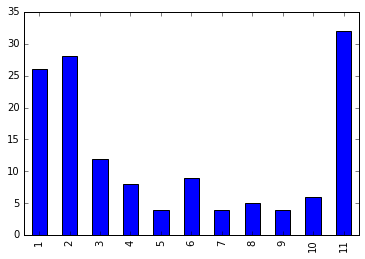

In [96]:
pd.Series(collections.Counter(participation_intro[pi]['tasks'] 
                              for pi in participation_intro)).plot(kind='bar');
collections.Counter(participation_intro[pi]['tasks'] 
                    for pi in participation_intro)

Counter({0: 10, 1: 46, 2: 9, 3: 9, 4: 5, 5: 8, 6: 6, 7: 5, 8: 4, 9: 3, 10: 33})

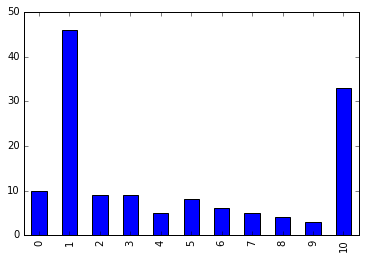

In [97]:
pd.Series(collections.Counter(participation[pi]['consecutive'] 
                              for pi in participation)).plot(kind='bar');
collections.Counter(participation[pi]['consecutive'] for pi in participation)

Counter({0: 34,
         1: 7,
         2: 22,
         3: 6,
         4: 7,
         5: 5,
         6: 8,
         7: 5,
         8: 5,
         9: 4,
         10: 3,
         11: 32})

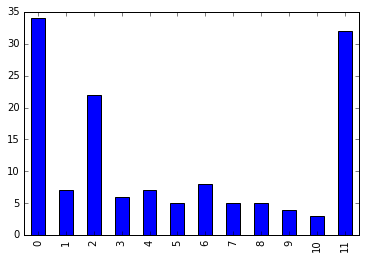

In [98]:
pd.Series(collections.Counter(participation_intro[pi]['consecutive'] 
                              for pi in participation_intro)).plot(kind='bar');
collections.Counter(participation_intro[pi]['consecutive'] for pi in participation_intro)

# Midnight starters

In [99]:
pipeline = [
    {'$match': {'completed': {'$exists': True}}},
    {'$project': {'icma_number': True, 'Personal Identifier': True,
                  'hour': {'$hour': '$started'}}},
    {'$match': {'hour': 0}}] 
midnight_completed_starts = pd.DataFrame(
   [{'icma_number': r['icma_number'], 'pi': r['Personal Identifier']} 
    for r in icmas.aggregate(pipeline)
])
midnight_completed_starts_x = pd.crosstab(midnight_completed_starts.pi, midnight_completed_starts.icma_number)
midnight_completed_starts_x;

In [100]:
midnight_completed_starts_x.shape

(26, 11)

In [101]:
# How many attempts were started before 1.00am for each task?
midnight_completed_starts_x.sum()

icma_number
0      2
1      5
2     10
3      6
4     10
5      9
6      7
7      9
8      4
9      7
10     9
dtype: int64

In [102]:
# How many attempts were started before 1.00am for each task?
midnight_completed_starts_x.sum().to_frame().T.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>icma_number</th>\n      <th>0</th>\n      <th>1</th>\n      <th>2</th>\n      <th>3</th>\n      <th>4</th>\n      <th>5</th>\n      <th>6</th>\n      <th>7</th>\n      <th>8</th>\n      <th>9</th>\n      <th>10</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>2</td>\n      <td>5</td>\n      <td>10</td>\n      <td>6</td>\n      <td>10</td>\n      <td>9</td>\n      <td>7</td>\n      <td>9</td>\n      <td>4</td>\n      <td>7</td>\n      <td>9</td>\n    </tr>\n  </tbody>\n</table>'

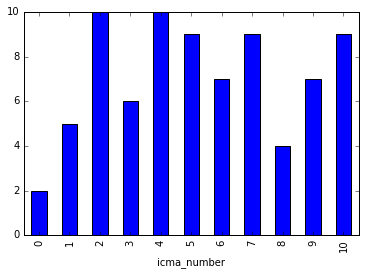

In [103]:
midnight_completed_starts_x.sum().plot(kind='bar')

In [104]:
midnight_completed_starts_x.sum(axis=1);

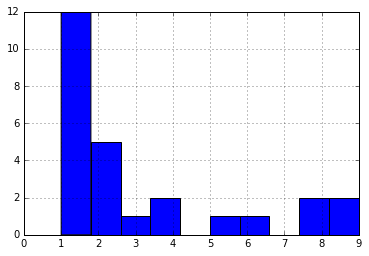

In [105]:
# How many people made this many midnight starts? 
# e.g. 12 people did one mightnight start, 5 people did two, 2 people did nine
midnight_completed_starts_x.sum(axis=1).hist()

# Get participant data


In [106]:
pis = icmas.distinct('Personal Identifier')
len(pis)

305

In [107]:
participant_df = pd.DataFrame([icmas.find_one({'Personal Identifier': pi}, 
                                              ['First name', 'Surname', 'Email address', 'Personal Identifier']) 
              for pi in icmas.distinct('Personal Identifier')])
participant_df = participant_df[['Email address', 'First name', 'Surname', 'Personal Identifier']]
participant_df;

In [108]:
# participant_df.to_csv('survey-email.csv', index=False, header=False)

In [109]:
pi1s = set([r['Personal Identifier'] for r in icmas.find({'icma_number': {'$ne': 0}})])
participant_1_df = pd.DataFrame([icmas.find_one({'Personal Identifier': pi}, 
                                              ['First name', 'Surname', 'Email address', 'Personal Identifier']) 
              for pi in pi1s])
participant_1_df = participant_1_df[['Email address', 'First name', 'Surname', 'Personal Identifier']]
participant_1_df;

In [110]:
# participant_1_df.to_csv('survey-email_1.csv', index=False, header=False)

# Overall performance prizes

In [111]:
pipeline = [
    {'$match': {'completed': {'$exists': True}, 'icma_number': {'$gt': 0}}},
    {'$match': {'completed': {'$lt': datetime(2017, 7, 31)}}},
    {"$group": {"_id": {'icma_number': "$icma_number",
                                'grade': '$grade'},
                        "participants": {"$addToSet": '$Personal Identifier'}}}]
july_grades = {(r['_id']['icma_number'], r['_id']['grade']): r['participants'] 
                      for r in icmas.aggregate(pipeline)}
july_grades;

In [112]:
icma_numbers = sorted(set(k[0] for k in july_grades))
best_grades_july = {}
for icma in icma_numbers:
    prps = set()
    for grade in [10, 5, 0, '-']:
        pis = set(july_grades.get((icma, grade), []))
        best_grades_july[icma, grade] = pis - prps
        prps |= pis
best_grades_july;

In [113]:
pbgs = [{'pi': pi, 'icma': icma, 'grade': grade} 
        for ((icma, grade), pis) in best_grades_july.items() 
        for pi in pis]
ps = set(p['pi'] for p in pbgs)
july_best_grades = {pi: {p['icma']: p['grade'] 
                                for p in pbgs
                                if p['pi'] == pi}
                           for pi in ps}
july_best_grades;

In [114]:
july_scores = {k: sum(scores.values())
              for k, scores in july_best_grades.items()}
july_scores.values()

dict_values([15, 0, 30, 30, 30, 70, 5, 30, 100, 10, 100, 90, 60, 100, 50, 80, 90, 50, 70, 20, 45, 60, 100, 90, 20, 100, 100, 30, 100, 100, 100, 30, 30, 5, 100, 20, 30, 100, 50, 10, 0, 40, 100, 50, 100, 80, 20, 30, 90, 50, 70, 10, 40, 65, 30, 30, 20, 100, 95, 50, 60, 10, 20, 25, 50, 15, 40, 10, 70, 40, 100, 100, 15, 40, 80, 90, 40, 10, 10])

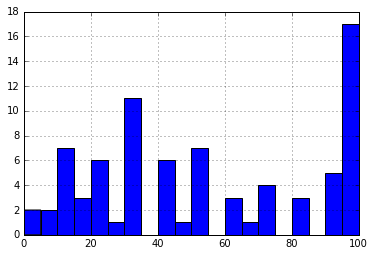

In [115]:
pd.Series(list(july_scores.values())).hist(bins=20)

In [116]:
sum(1 for pi in july_scores if july_scores[pi] >= 100)

16

In [117]:
sum(1 for pi in july_scores if july_scores[pi] >= 80 if july_scores[pi] < 100)

9

In [118]:
[(pi, 
  icmas.find_one({'Personal Identifier': pi})['First name'],
  icmas.find_one({'Personal Identifier': pi})['Surname']) 
 for pi in july_scores if july_scores[pi] >= 100];

In [119]:
winners = random.sample([pi for pi in july_scores if july_scores[pi] >= 100], 2)

# for w in winners:
#     winner = icmas.find_one({'Personal Identifier': w})
#     print('{} {} PI {} email {}'.format(
#         winner['First name'],
#         winner['Surname'],
#         winner['Personal Identifier'],
#         winner['Email address']
#         ));

In [120]:
[(pi, 
  icmas.find_one({'Personal Identifier': pi})['First name'],
  icmas.find_one({'Personal Identifier': pi})['Surname'])
 for pi in july_scores if july_scores[pi] >= 80 if july_scores[pi] < 100];

In [121]:
winners = random.sample([pi for pi in july_scores if july_scores[pi] >= 80 if july_scores[pi] < 100], 1)

# for w in winners:
#     winner = icmas.find_one({'Personal Identifier': w})
#     print('{} {} PI {} email {}'.format(
#         winner['First name'],
#         winner['Surname'],
#         winner['Personal Identifier'],
#         winner['Email address']
#         ));